In [22]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../creme/')
import creme
import utils
import custom_model
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Enformer and example sequences

In [23]:
track_index = [5111]
model = custom_model.Enformer(track_index=track_index)
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_line_info = {i: [t, utils.clean_cell_name(target_df.iloc[t]['description'])] for i, t in
              enumerate(track_index)}

In [24]:
fasta_path = f'../data/GRCh38.primary_assembly.genome.fa'
seq_parser = utils.SequenceParser(fasta_path)

gene = 'GATA2_chr3_128487916_-'

gene_name, chrom, start, strand = gene.split('_')
wt_seq = seq_parser.extract_seq_centered(chrom, int(start), '-', model.seq_length)


In [25]:
# TSS bin indeces
bins = [447, 448]

In [26]:
wt = model.predict(wt_seq)[0,:,0]


<Axes: >

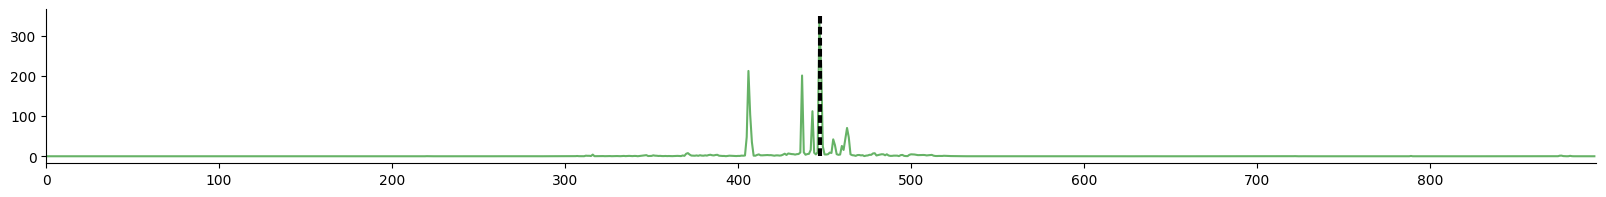

In [27]:
utils.plot_track([wt], color='green', zoom=[0, 896], marks=bins)


# Sufficiency test
In this example we will test the necessity of (5Kb) tiles in the context of an enhancing context sequence of ABCA8 gene. 

To run context swap test we need:
- a loaded model
- onehot encoded sequence (WT) of the sequence
- TSS tile coordinates (or any other fixed tile coordinate that is always embedded in the shuffled backgrounds)
- a list of tile coordinates to test
- num_shuffle - number of shuffles to perform
- tile sequence (onehot) which can be extracted based on coordinates (if tile_seq is None)
- optionally, we can set mean=False to not average the shuffle results
- optionally, we can set return_seqs to True to return the shuffled sequeneces for future use


In [28]:
perturb_window = 5000
N_shuffles = 10
tss_tile, cre_tiles = utils.set_tile_range(model.seq_length, perturb_window)
cre_tiles = cre_tiles[19:20]
print(f'Enhancing tile at position {cre_tiles[0][0]} - {cre_tiles[0][1]}')
print(f'TSS tile at center position {tss_tile[0]} - {tss_tile[1]}')

Enhancing tile at position 100804 - 105804
TSS tile at center position 95804 - 100804


## Sufficiency of an enhancing tile of GATA2 gene TSS
As we can see, the GATA2 TSS activity is low on its own (control case of just TSS) compared to the high activity of the WT. 
However, when we embed the enhancing CRE together with the TSS the activity goes back up (not fully but to a much higher level than 
the control case).

In [29]:
_, pred_mut, pred_control = creme.sufficiency_test(model, wt_seq, tss_tile, cre_tiles, N_shuffles, mean=False)

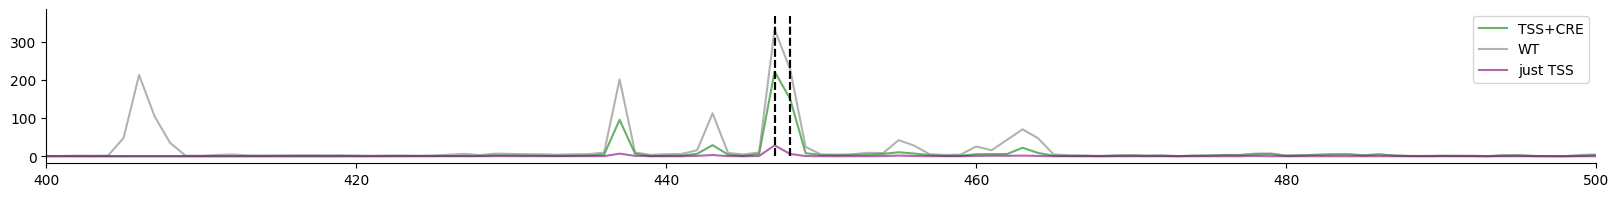

In [38]:
ax=utils.plot_track(pred_mut.mean(axis=1)[:,:,0], color='green', label='TSS+CRE')
utils.plot_track([wt], ax=ax, zoom=[400, 500], marks=[447,448], color='grey', label='WT')
utils.plot_track(pred_control.mean(axis=1)[:,:,0], color='purple', label='just TSS', ax=ax, zoom=[400, 500], marks=[447,448])
ax.legend();